# EDA: E-commerce Fraud Data

**Business Objective**: Understand fraud patterns in e-commerce transactions to inform feature engineering and model development.

**Key Questions**:
1. What is the class imbalance ratio? (Critical for resampling strategy)
2. Which features correlate most strongly with fraud?
3. Are there temporal patterns in fraud?
4. What are the risk indicators by user behavior, device, and location?


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Add src to path - works in both Jupyter and regular Python
# Method 1: Try relative path (works when running from notebooks directory)
src_path_rel = Path('../src').resolve()
if src_path_rel.exists() and str(src_path_rel) not in sys.path:
    sys.path.insert(0, str(src_path_rel))

# Method 2: Try absolute path from current working directory
src_path_abs = Path.cwd().parent / 'src' if Path.cwd().name == 'notebooks' else Path.cwd() / 'src'
if src_path_abs.exists() and str(src_path_abs) not in sys.path:
    sys.path.insert(0, str(src_path_abs))

# Import custom modules
from data_loader import load_fraud_data, load_ip_country_mapping, validate_data_quality
from preprocessing import clean_fraud_data, add_geolocation_features, engineer_time_features

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")


Libraries imported successfully


## 1. Data Loading and Initial Inspection


In [13]:
# Load fraud data
# Resolve path correctly regardless of working directory
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_path = project_root / 'data' / 'raw' / 'Fraud_Data.csv'

try:
    # Try absolute path first
    if data_path.exists():
        df = load_fraud_data(str(data_path))
        print(f"✓ Fraud data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
        print(f"\nColumns: {list(df.columns)}")
    else:
        # Try relative path as fallback
        rel_path = Path("../data/raw/Fraud_Data.csv").resolve()
        if rel_path.exists():
            df = load_fraud_data(str(rel_path))
            print(f"✓ Fraud data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
            print(f"\nColumns: {list(df.columns)}")
        else:
            raise FileNotFoundError(f"Fraud data file not found at {data_path} or {rel_path}")
except FileNotFoundError as e:
    print(f"⚠ Data file not found: {e}")
    print(f"   Current working directory: {Path.cwd()}")
    print(f"   Looking for file at: {data_path}")
    print(f"   File exists: {data_path.exists()}")
    df = None
except Exception as e:
    print(f"⚠ Error loading data: {e}")
    import traceback
    traceback.print_exc()
    df = None


✓ Fraud data loaded: 151,112 rows, 11 columns

Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']


In [14]:
# Initial data inspection
if df is not None:
    print("=" * 60)
    print("DATA OVERVIEW")
    print("=" * 60)
    print(f"\nShape: {df.shape}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nFirst few rows:")
    display(df.head())
    print(f"\nBasic Statistics:")
    display(df.describe())


DATA OVERVIEW

Shape: (151112, 11)

Data Types:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

First few rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0



Basic Statistics:


,user_id,signup_time,purchase_time,purchase_value,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,2015-04-20 00:56:09.511329280,2015-06-16 02:56:38.759952896,36.935372,33.140704,2.152145e+09,0.093646
min,2.000000,2015-01-01 00:00:42,2015-01-01 00:00:44,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,2015-08-18 04:40:29,2015-12-16 02:56:05,154.000000,76.000000,4.294850e+09,1.000000
std,115369.285024,NaN,NaN,18.322762,8.617733,1.248497e+09,0.291336


## 2. Data Quality Assessment


In [15]:
# Validate data quality
if df is not None:
    quality_report = validate_data_quality(df, "Fraud_Data")
    
    print("=" * 60)
    print("DATA QUALITY REPORT")
    print("=" * 60)
    
    # Missing values analysis
    missing = pd.DataFrame({
        'Column': df.columns,
        'Missing Count': [quality_report['missing_values'][col] for col in df.columns],
        'Missing %': [quality_report['missing_percentage'][col] for col in df.columns]
    }).sort_values('Missing Count', ascending=False)
    
    missing = missing[missing['Missing Count'] > 0]
    
    if len(missing) > 0:
        print("\n⚠ Missing Values Detected:")
        display(missing)
        
        # Visualize missing values
        plt.figure(figsize=(10, 6))
        sns.barplot(data=missing, x='Column', y='Missing %')
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Missing Percentage (%)')
        plt.tight_layout()
        plt.show()
    else:
        print("\n✓ No missing values detected")
    
    # Duplicates
    print(f"\n✓ Duplicates: {quality_report['duplicates']} ({quality_report['duplicates']/len(df)*100:.2f}%)")


DATA QUALITY REPORT

✓ No missing values detected

✓ Duplicates: 0 (0.00%)


## 3. Class Distribution Analysis (CRITICAL FOR BUSINESS)

**Business Impact**: Class imbalance directly affects model performance and business metrics.


CLASS DISTRIBUTION ANALYSIS

Absolute Counts:
  Non-Fraud (0): 136,961 (90.64%)
  Fraud (1):     14,151 (9.36%)

Imbalance Ratio: 9.68:1 (Non-Fraud:Fraud)


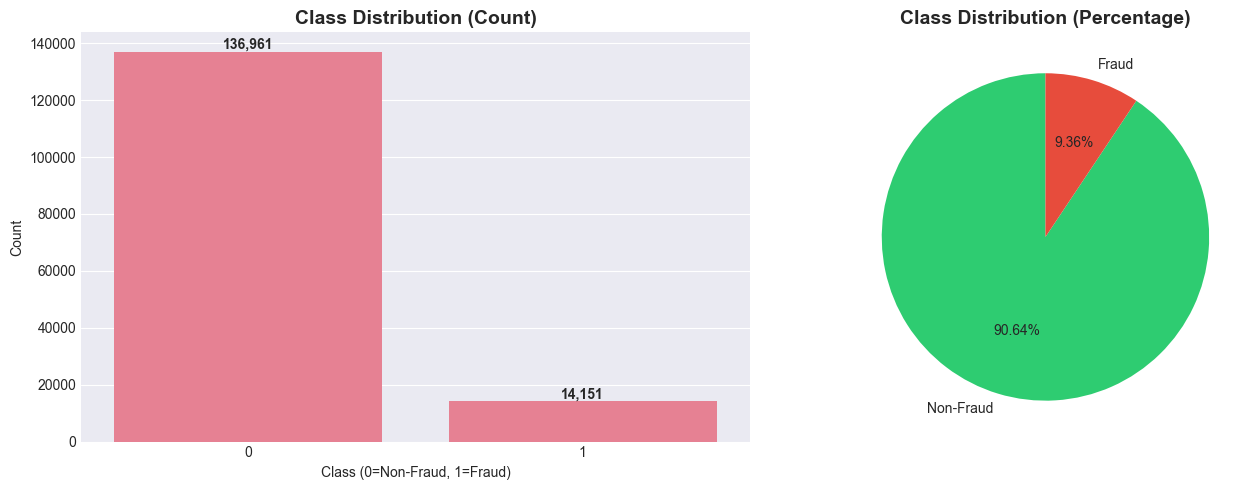


BUSINESS INTERPRETATION
⚠ MODERATE IMBALANCE: Fraud rate 5-20%
   → SMOTE or weighted classes recommended
   → Balanced accuracy is important


In [16]:
# Class distribution analysis
if df is not None and 'class' in df.columns:
    class_dist = df['class'].value_counts()
    class_pct = df['class'].value_counts(normalize=True) * 100
    
    print("=" * 60)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 60)
    print(f"\nAbsolute Counts:")
    print(f"  Non-Fraud (0): {class_dist[0]:,} ({class_pct[0]:.2f}%)")
    print(f"  Fraud (1):     {class_dist[1]:,} ({class_pct[1]:.2f}%)")
    print(f"\nImbalance Ratio: {class_dist[0]/class_dist[1]:.2f}:1 (Non-Fraud:Fraud)")
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    sns.countplot(data=df, x='class', ax=axes[0])
    axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(class_dist):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
    
    # Percentage plot
    axes[1].pie(class_dist.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', 
                startangle=90, colors=['#2ecc71', '#e74c3c'])
    axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Business interpretation
    print("\n" + "=" * 60)
    print("BUSINESS INTERPRETATION")
    print("=" * 60)
    if class_pct[1] < 5:
        print("⚠ SEVERE IMBALANCE: Fraud rate < 5%")
        print("   → SMOTE recommended to create synthetic fraud samples")
        print("   → Cost-sensitive learning may be necessary")
        print("   → Focus on precision-recall curve, not just accuracy")
    elif class_pct[1] < 20:
        print("⚠ MODERATE IMBALANCE: Fraud rate 5-20%")
        print("   → SMOTE or weighted classes recommended")
        print("   → Balanced accuracy is important")
    else:
        print("✓ RELATIVELY BALANCED: Fraud rate > 20%")
        print("   → Standard resampling may suffice")


## 4. Univariate Analysis


NUMERICAL FEATURES ANALYSIS


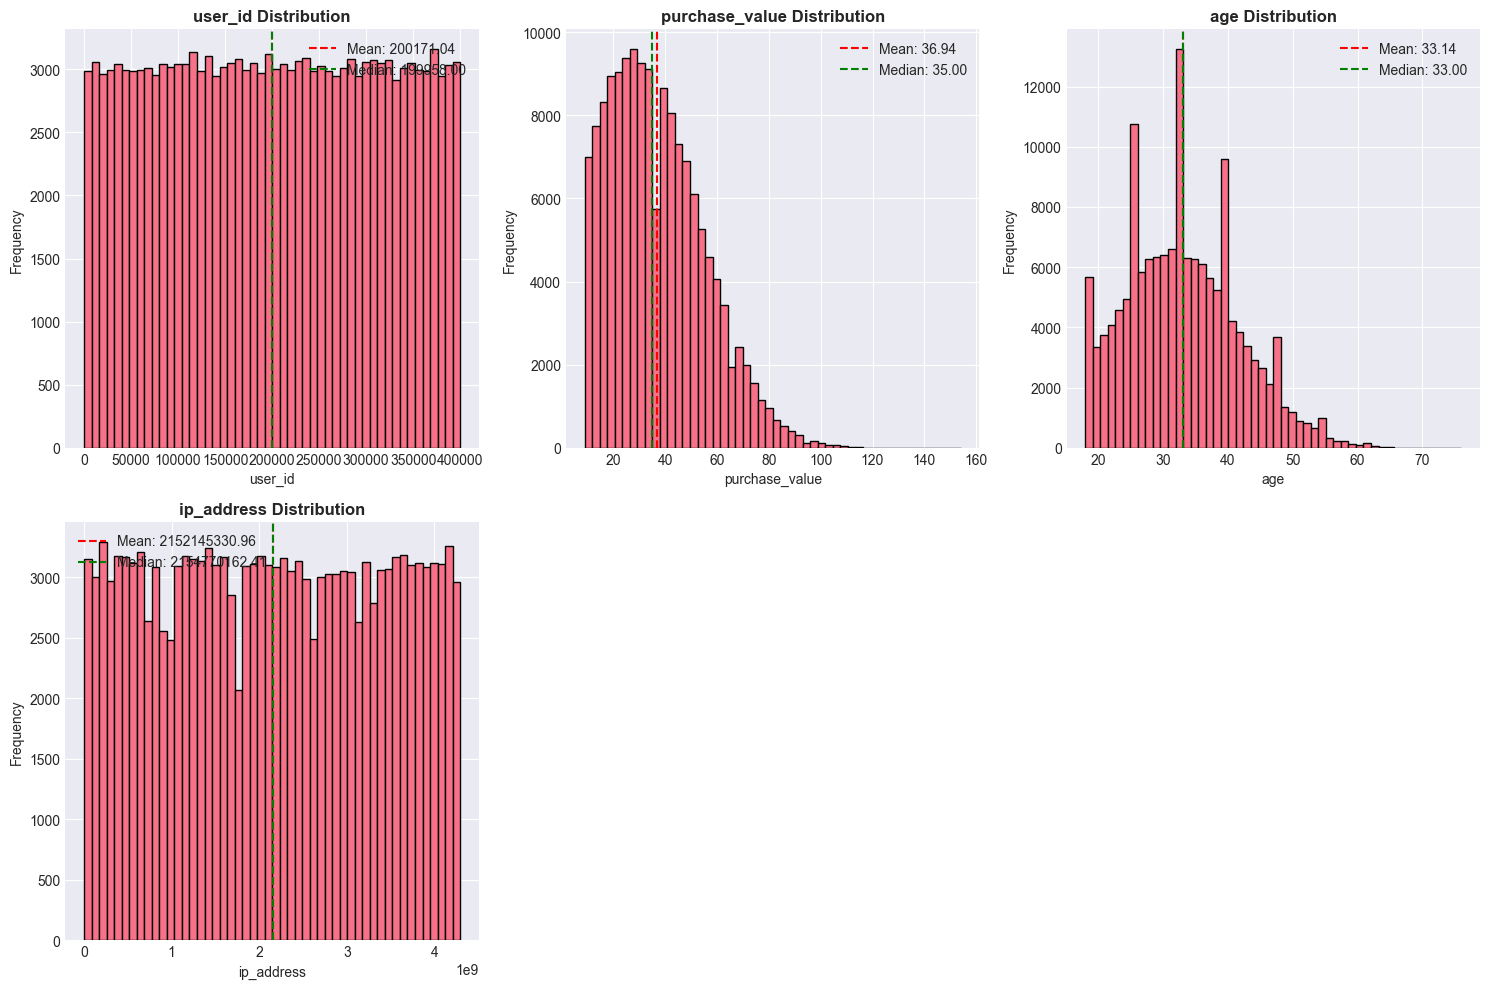


Outlier Analysis (IQR Method):
  user_id: 0 outliers (0.00%)
  purchase_value: 1,067 outliers (0.71%)
  age: 776 outliers (0.51%)
  ip_address: 0 outliers (0.00%)


In [17]:
# Analyze numerical features
if df is not None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numeric_cols:
        numeric_cols.remove('class')
    
    if len(numeric_cols) > 0:
        print("=" * 60)
        print("NUMERICAL FEATURES ANALYSIS")
        print("=" * 60)
        
        # Distribution plots
        n_cols = min(3, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(numeric_cols):
            if idx < len(axes):
                df[col].hist(bins=50, ax=axes[idx], edgecolor='black')
                axes[idx].set_title(f'{col} Distribution', fontweight='bold')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Frequency')
                
                # Add statistics
                mean_val = df[col].mean()
                median_val = df[col].median()
                axes[idx].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
                axes[idx].axvline(median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
                axes[idx].legend()
        
        # Hide extra subplots
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Outlier detection using IQR
        print("\nOutlier Analysis (IQR Method):")
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_pct = len(outliers) / len(df) * 100
            print(f"  {col}: {len(outliers):,} outliers ({outlier_pct:.2f}%)")


CATEGORICAL FEATURES ANALYSIS

device_id:
device_id
ITUMJCKWEYNDD    20
CQTUVBYIWWWBC    20
EQYVNEGOFLAWK    20
NGQCKIADMZORL    20
KIPFSCNUGOLDP    20
ZUSVMDEZRBDTX    20
IGKYVZDBEGALB    19
CDFXVYHOIHPYP    19
EGLGSEGYPMMAM    19
SDJQRPKXQFBED    19
Name: count, dtype: int64


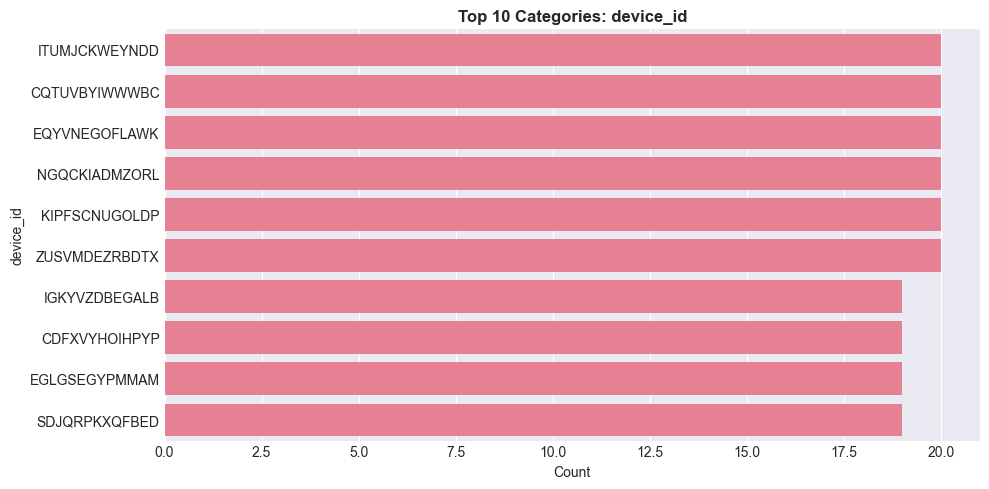


source:
source
SEO       60615
Ads       59881
Direct    30616
Name: count, dtype: int64


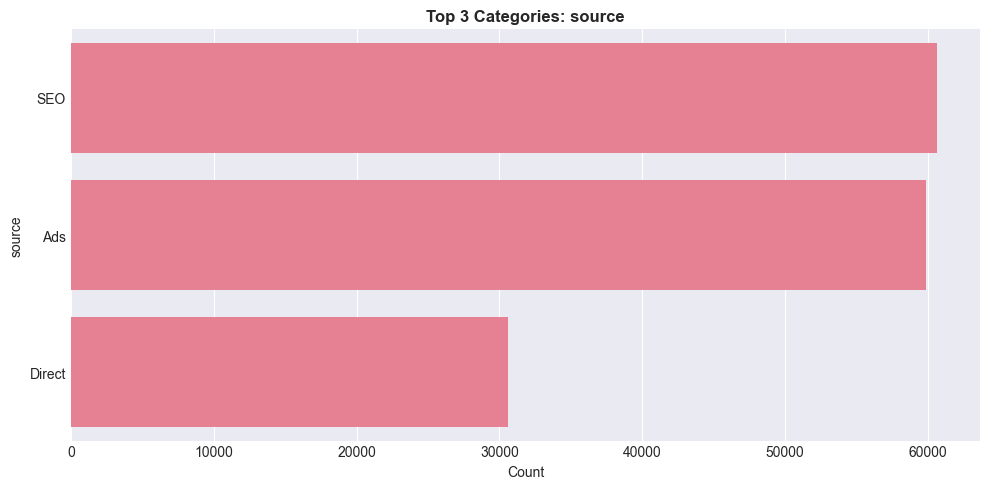


browser:
browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64


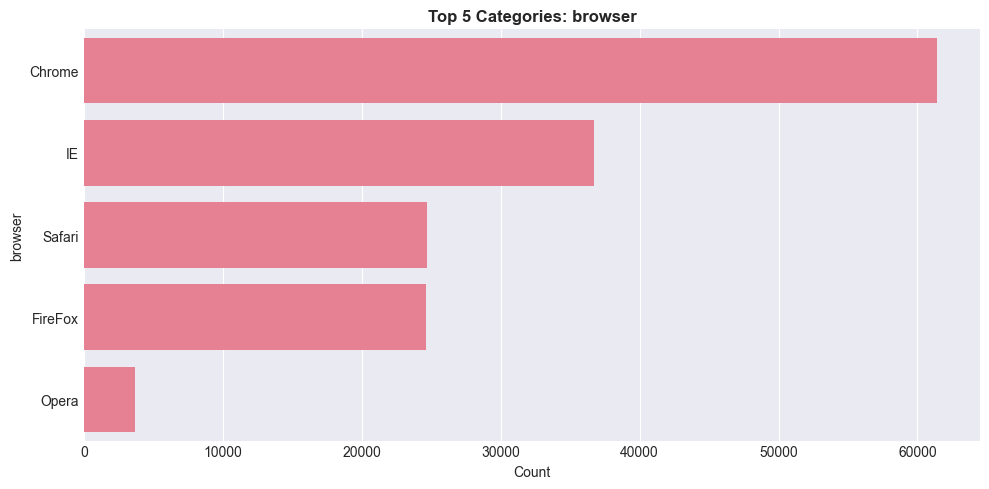


sex:
sex
M    88293
F    62819
Name: count, dtype: int64


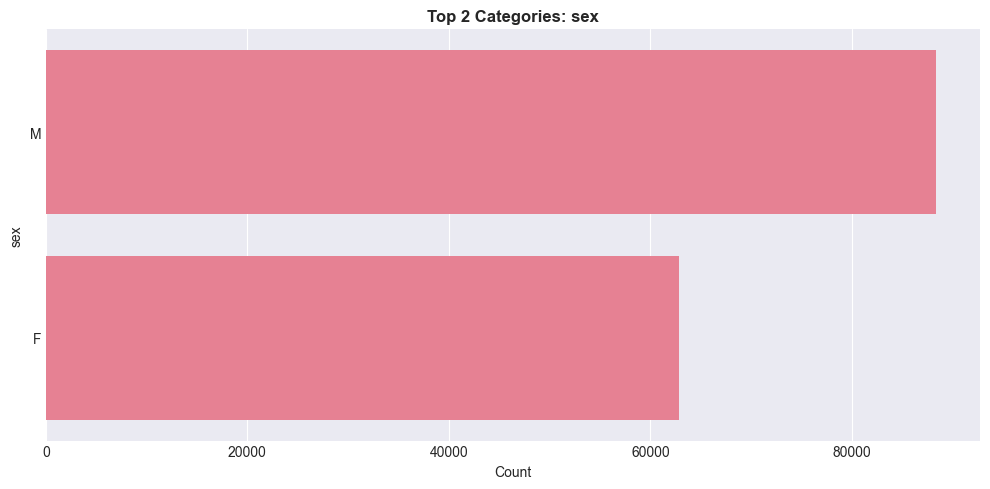

In [18]:
# Analyze categorical features
if df is not None:
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if len(categorical_cols) > 0:
        print("=" * 60)
        print("CATEGORICAL FEATURES ANALYSIS")
        print("=" * 60)
        
        for col in categorical_cols:
            print(f"\n{col}:")
            value_counts = df[col].value_counts()
            print(value_counts.head(10))
            
            # Visualize top categories
            plt.figure(figsize=(10, 5))
            top_n = min(10, len(value_counts))
            sns.barplot(x=value_counts.head(top_n).values, y=value_counts.head(top_n).index)
            plt.title(f'Top {top_n} Categories: {col}', fontweight='bold')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()


## 5. Bivariate Analysis: Features vs Fraud


FEATURE-FRAUD RELATIONSHIP ANALYSIS


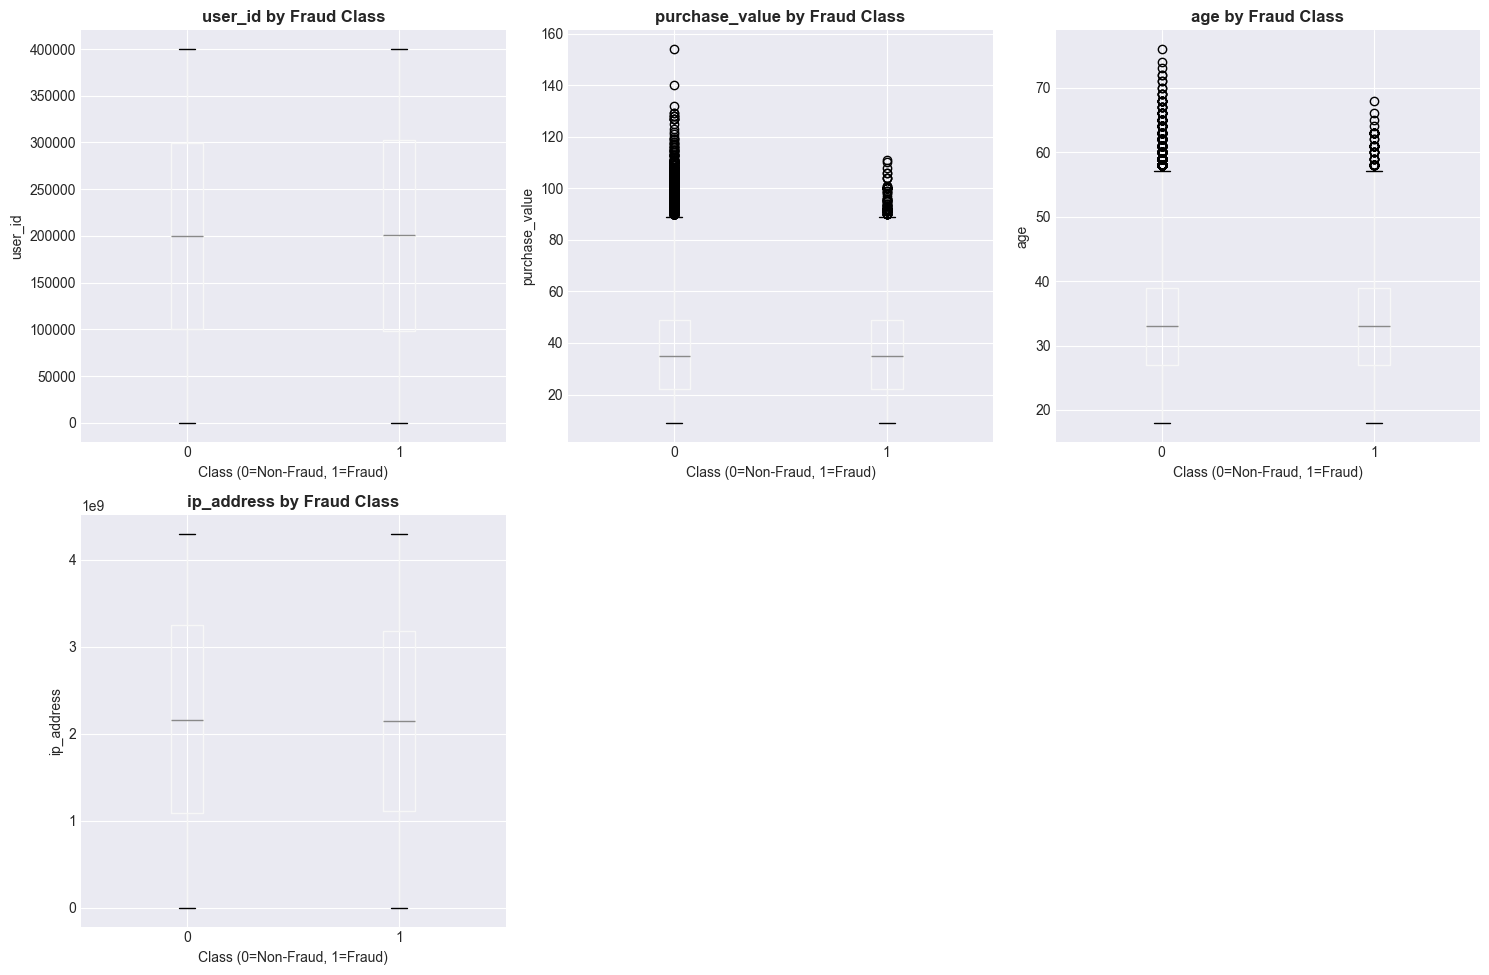


Mean Values by Class:
  user_id:
    Non-Fraud: 200098.92
    Fraud:     200869.07 (diff: +0.38%)
  purchase_value:
    Non-Fraud: 36.93
    Fraud:     36.99 (diff: +0.17%)
  age:
    Non-Fraud: 33.12
    Fraud:     33.32 (diff: +0.59%)
  ip_address:
    Non-Fraud: 2154235239.81
    Fraud:     2131918067.39 (diff: -1.04%)


In [19]:
# Analyze relationship between features and fraud
if df is not None and 'class' in df.columns:
    print("=" * 60)
    print("FEATURE-FRAUD RELATIONSHIP ANALYSIS")
    print("=" * 60)
    
    # Numerical features vs fraud
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numeric_cols:
        numeric_cols.remove('class')
    
    if len(numeric_cols) > 0:
        # Box plots for numerical features
        n_cols = min(3, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(numeric_cols):
            if idx < len(axes):
                df.boxplot(column=col, by='class', ax=axes[idx])
                axes[idx].set_title(f'{col} by Fraud Class', fontweight='bold')
                axes[idx].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
                axes[idx].set_ylabel(col)
        
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('')
        plt.tight_layout()
        plt.show()
        
        # Statistical test: Mean difference
        print("\nMean Values by Class:")
        for col in numeric_cols:
            fraud_mean = df[df['class'] == 1][col].mean()
            non_fraud_mean = df[df['class'] == 0][col].mean()
            diff_pct = ((fraud_mean - non_fraud_mean) / non_fraud_mean) * 100
            print(f"  {col}:")
            print(f"    Non-Fraud: {non_fraud_mean:.2f}")
            print(f"    Fraud:     {fraud_mean:.2f} (diff: {diff_pct:+.2f}%)")



Fraud Rate by Categorical Features:

device_id:


,device_id,total_count,fraud_count,fraud_rate
137893,ZZQBRNNATFEIW,1,1,1.0
5224,AZEVNCBGICKDR,1,1,1.0
5378,AZZLCBJLPGRBI,1,1,1.0
5432,BAGDZEFHKRGSI,1,1,1.0
23,AADGMPYOPXXCX,1,1,1.0
5485,BAOFXLDTJDTJY,1,1,1.0
5492,BAOUUZUHXFBOQ,1,1,1.0
5499,BAPOCHODFYUGD,1,1,1.0
5519,BARXZJLLJCVDI,1,1,1.0
5571,BAXIZLRAOHJQY,1,1,1.0


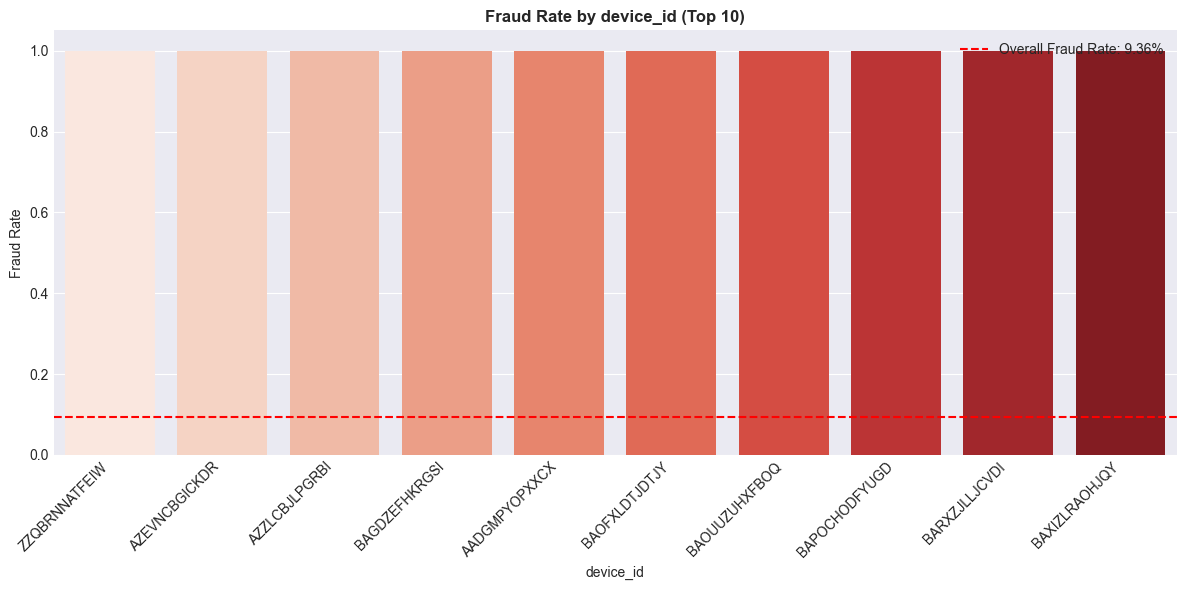


source:


,source,total_count,fraud_count,fraud_rate
1,Direct,30616,3226,0.105370
0,Ads,59881,5513,0.092066
2,SEO,60615,5412,0.089285


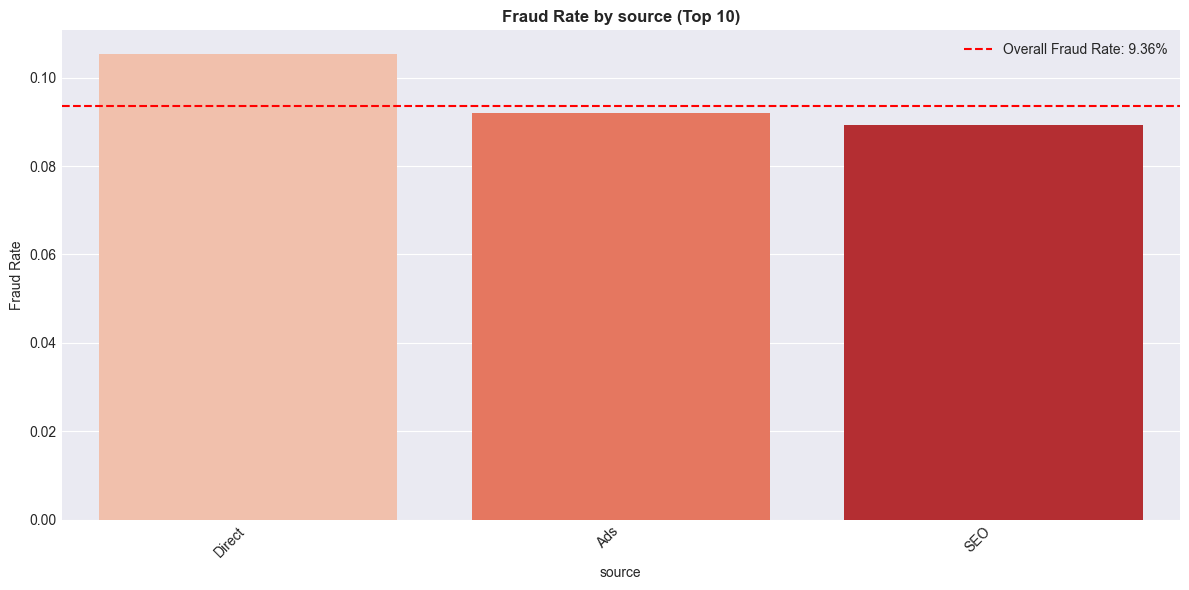


browser:


,browser,total_count,fraud_count,fraud_rate
0,Chrome,61432,6069,0.098792
1,FireFox,24610,2342,0.095165
4,Safari,24667,2225,0.090201
3,Opera,3676,328,0.089227
2,IE,36727,3187,0.086775


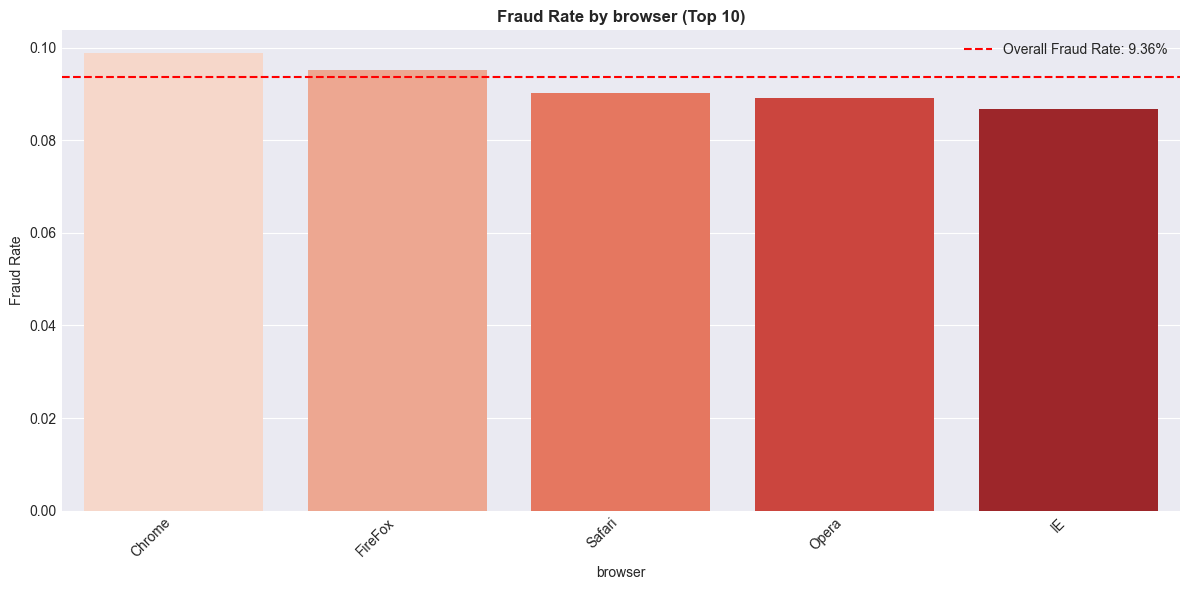


sex:


,sex,total_count,fraud_count,fraud_rate
1,M,88293,8434,0.095523
0,F,62819,5717,0.091007


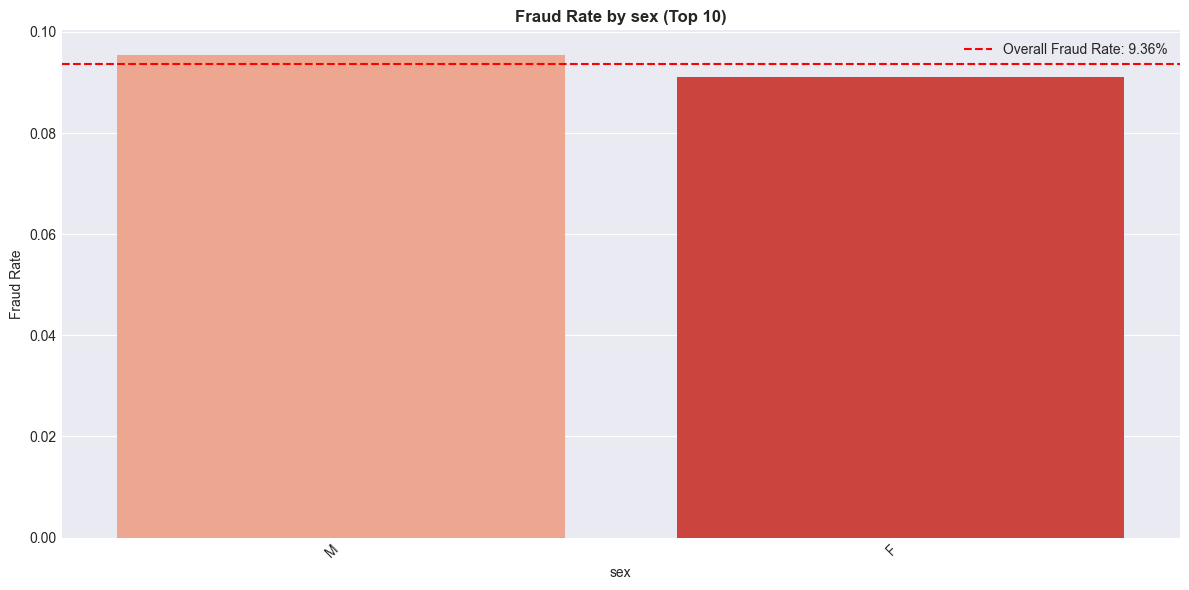

In [20]:
# Categorical features vs fraud
if df is not None and 'class' in df.columns:
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if len(categorical_cols) > 0:
        print("\nFraud Rate by Categorical Features:")
        
        for col in categorical_cols:
            fraud_rates = df.groupby(col)['class'].agg(['count', 'sum', 'mean']).reset_index()
            fraud_rates.columns = [col, 'total_count', 'fraud_count', 'fraud_rate']
            fraud_rates = fraud_rates.sort_values('fraud_rate', ascending=False)
            
            print(f"\n{col}:")
            display(fraud_rates.head(10))
            
            # Visualize fraud rates
            top_categories = fraud_rates.head(10)
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_categories, x=col, y='fraud_rate', palette='Reds')
            plt.title(f'Fraud Rate by {col} (Top 10)', fontweight='bold')
            plt.xlabel(col)
            plt.ylabel('Fraud Rate')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=df['class'].mean(), color='r', linestyle='--', 
                       label=f'Overall Fraud Rate: {df["class"].mean():.2%}')
            plt.legend()
            plt.tight_layout()
            plt.show()


## 6. Temporal Analysis


TEMPORAL FRAUD PATTERNS


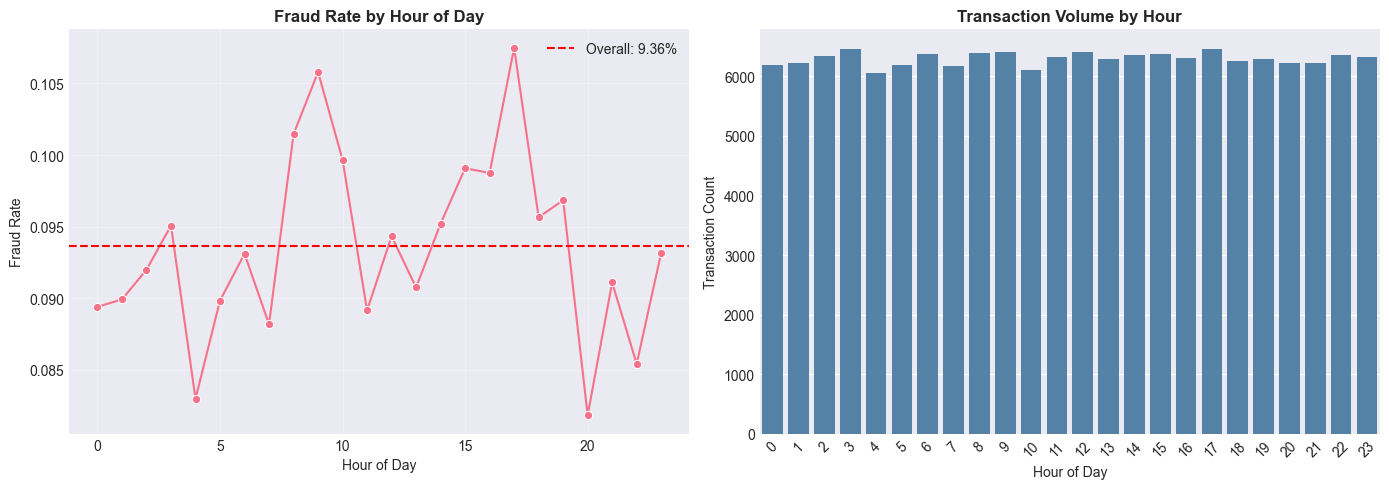


High-Risk Hours (Fraud Rate > Overall Average):


,hour,fraud_rate
3,3,0.095076
8,8,0.101456
9,9,0.105796
10,10,0.099672
12,12,0.094331
14,14,0.095201
15,15,0.099074
16,16,0.098748
17,17,0.107485
18,18,0.095649


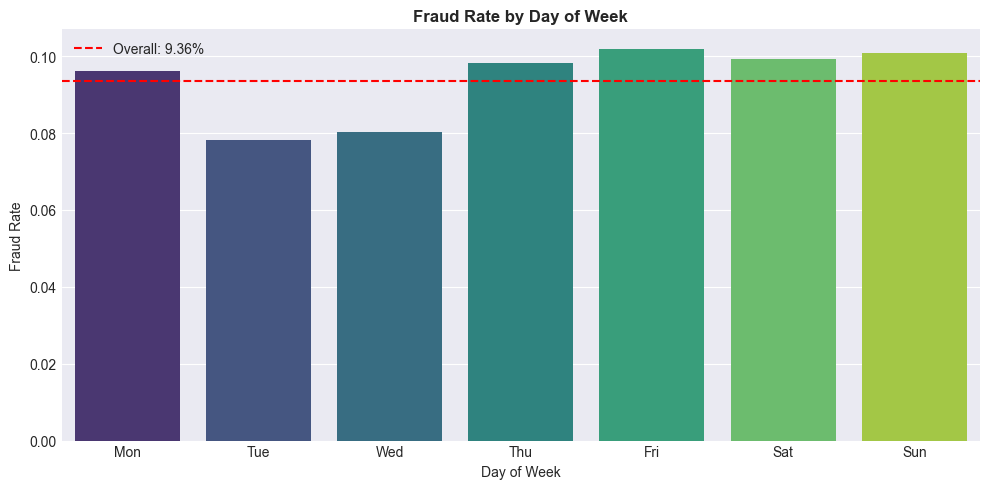

In [21]:
# Temporal patterns in fraud
if df is not None and 'purchase_time' in df.columns:
    df_time = engineer_time_features(df.copy())
    
    print("=" * 60)
    print("TEMPORAL FRAUD PATTERNS")
    print("=" * 60)
    
    # Fraud by hour of day
    if 'hour_of_day' in df_time.columns:
        fraud_by_hour = df_time.groupby('hour_of_day')['class'].agg(['count', 'sum', 'mean']).reset_index()
        fraud_by_hour.columns = ['hour', 'total', 'fraud_count', 'fraud_rate']
        
        plt.figure(figsize=(14, 5))
        ax1 = plt.subplot(1, 2, 1)
        sns.lineplot(data=fraud_by_hour, x='hour', y='fraud_rate', marker='o', ax=ax1)
        ax1.set_title('Fraud Rate by Hour of Day', fontweight='bold')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Fraud Rate')
        ax1.axhline(y=df_time['class'].mean(), color='r', linestyle='--', 
                    label=f'Overall: {df_time["class"].mean():.2%}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(1, 2, 2)
        sns.barplot(data=fraud_by_hour, x='hour', y='total', ax=ax2, color='steelblue')
        ax2.set_title('Transaction Volume by Hour', fontweight='bold')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Transaction Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\nHigh-Risk Hours (Fraud Rate > Overall Average):")
        high_risk_hours = fraud_by_hour[fraud_by_hour['fraud_rate'] > df_time['class'].mean()]
        display(high_risk_hours[['hour', 'fraud_rate']])
    
    # Fraud by day of week
    if 'day_of_week' in df_time.columns:
        fraud_by_dow = df_time.groupby('day_of_week')['class'].agg(['count', 'sum', 'mean']).reset_index()
        fraud_by_dow.columns = ['day', 'total', 'fraud_count', 'fraud_rate']
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        fraud_by_dow['day_name'] = fraud_by_dow['day'].apply(lambda x: day_names[x] if x < 7 else 'Unknown')
        
        plt.figure(figsize=(10, 5))
        sns.barplot(data=fraud_by_dow, x='day_name', y='fraud_rate', palette='viridis')
        plt.title('Fraud Rate by Day of Week', fontweight='bold')
        plt.xlabel('Day of Week')
        plt.ylabel('Fraud Rate')
        plt.axhline(y=df_time['class'].mean(), color='r', linestyle='--', 
                   label=f'Overall: {df_time["class"].mean():.2%}')
        plt.legend()
        plt.tight_layout()
        plt.show()


## 7. Data Cleaning


In [22]:
# Clean the data
if df is not None:
    print("=" * 60)
    print("DATA CLEANING")
    print("=" * 60)
    
    initial_shape = df.shape
    df_clean = clean_fraud_data(df.copy())
    final_shape = df_clean.shape
    
    print(f"\nBefore cleaning: {initial_shape[0]:,} rows")
    print(f"After cleaning:  {final_shape[0]:,} rows")
    print(f"Rows removed:    {initial_shape[0] - final_shape[0]:,}")
    
    # Save cleaned data
    output_path = Path("../data/processed/fraud_data_cleaned.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df_clean.to_csv(output_path, index=False)
    print(f"\n✓ Cleaned data saved to: {output_path}")
    
    df = df_clean  # Use cleaned data for remaining analysis


DATA CLEANING

Before cleaning: 151,112 rows
After cleaning:  151,112 rows
Rows removed:    0

✓ Cleaned data saved to: ..\data\processed\fraud_data_cleaned.csv


## 8. Key Business Insights Summary

**Critical Findings for Model Development:**


In [23]:
# Generate summary insights
if df is not None and 'class' in df.columns:
    print("=" * 60)
    print("KEY BUSINESS INSIGHTS")
    print("=" * 60)
    
    fraud_rate = df['class'].mean()
    print(f"\n1. CLASS IMBALANCE:")
    print(f"   - Overall fraud rate: {fraud_rate:.2%}")
    print(f"   - Imbalance ratio: {len(df[df['class']==0])/len(df[df['class']==1]):.1f}:1")
    print(f"   - Recommendation: Apply SMOTE with sampling_strategy=0.5")
    
    if 'purchase_value' in df.columns:
        fraud_value_mean = df[df['class']==1]['purchase_value'].mean()
        non_fraud_value_mean = df[df['class']==0]['purchase_value'].mean()
        print(f"\n2. TRANSACTION VALUE:")
        print(f"   - Average fraud transaction: ${fraud_value_mean:.2f}")
        print(f"   - Average legitimate transaction: ${non_fraud_value_mean:.2f}")
        print(f"   - Difference: {((fraud_value_mean - non_fraud_value_mean) / non_fraud_value_mean * 100):+.1f}%")
    
    if 'age' in df.columns:
        fraud_age_mean = df[df['class']==1]['age'].mean()
        non_fraud_age_mean = df[df['class']==0]['age'].mean()
        print(f"\n3. USER AGE:")
        print(f"   - Average fraud user age: {fraud_age_mean:.1f} years")
        print(f"   - Average legitimate user age: {non_fraud_age_mean:.1f} years")
    
    print(f"\n4. NEXT STEPS:")
    print(f"   - Integrate geolocation data (IP to Country)")
    print(f"   - Engineer velocity and frequency features")
    print(f"   - Create time-based features (hour, day, time since signup)")
    print(f"   - Prepare data for modeling with proper train-test split")
    
    print("\n" + "=" * 60)


KEY BUSINESS INSIGHTS

1. CLASS IMBALANCE:
   - Overall fraud rate: 9.36%
   - Imbalance ratio: 9.7:1
   - Recommendation: Apply SMOTE with sampling_strategy=0.5

2. TRANSACTION VALUE:
   - Average fraud transaction: $36.99
   - Average legitimate transaction: $36.93
   - Difference: +0.2%

3. USER AGE:
   - Average fraud user age: 33.3 years
   - Average legitimate user age: 33.1 years

4. NEXT STEPS:
   - Integrate geolocation data (IP to Country)
   - Engineer velocity and frequency features
   - Create time-based features (hour, day, time since signup)
   - Prepare data for modeling with proper train-test split

